Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Learning Gremlin - Create, Update, and Delete Queries

This notebook is the fourth in a series of notebooks that walk through how to write queries using Gremlin.  In this notebook, we will examine the basics of how to perform mutation operations, create/update/delete in Gremlin.  This notebook assumes that you have already completed the previous notebook "01-Basic-Read-Queries" so we will continue our lessons from the end of the previous notebook and assume that the data has been loaded into the cluster.

### Setting up the visualizations

Run the next two cells to configure various display options for our notebook, which we will use later on to display our results in a pleasing visual way.  

In [ ]:
%%graph_notebook_vis_options
{
  "groups": {    
    "person": {
      "color": "#9ac7bf"
    },
    "review": {
      "color": "#f8cecc"
    },
    "city": {
      "color": "#d5e8d4"
    },
    "state": {
      "color": "#dae8fc"
    },
    "review_rating": {
      "color": "#e1d5e7"
    },
    "restaurant": {
      "color": "#ffe6cc"
    },
    "cusine": {
      "color": "#fff2cc"
    }
  }
}

### Looking at our graph data

As we examined the data model in the previous notebook, we are not going to examine it, however we will leave the data schema for reference.

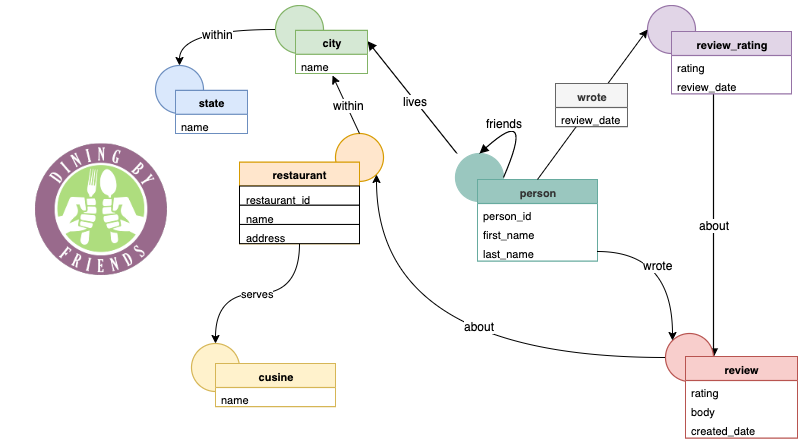


## Creating Data

When working with any database, one of the most common tasks is adding new data. To add new nodes, edges, or path in Gremlin we use the [`addV()`](https://tinkerpop.apache.org/docs/current/reference/#addvertex-step) step. 


### Creating a node with a label and properties
The simpliest option to create a node in Gremlin is to do a query similar to this:

```
g.addV()
```
This query will create a node with a default label (`vertex`) and no properties.  If we wanted to return the newly created element, we could by adding a [`next()`](https://tinkerpop.apache.org/docs/current/reference/#terminal-steps) step like shown here:

```
g.addV().next()
```

We can also create multiple elements simultaneously by combining `addV()` steps, as seen here:

```
g.addV().addV().next()
```

While these examples help in understanding the basic syntax, they are not very realistic.  In most scenarios you will not want to just add a node, instead you will want to add a node with a specific label and associated properties.

Let's look at what our query looks like to create a new `person` node with the first name of `John` and a last name of `Doe`.

In [ ]:
%%gremlin
g.addV('person').property('first_name','John').property('last_name','Doe').next()

In the example above, the first and last name properties were added by calling the `property()` step after the node is created.

### Creating multiple elements

As previously mentioned, you can chain `addV()` steps together to create multiple records in the same statement. This is shown in the query below:

In [ ]:
%%gremlin
g.addV('person').property('first_name','Fred').property('last_name','Doe')
.addV('person').property('first_name','Jane').property('last_name','Doe')

### Creating edges

Another common task is to create edges between nodes. To create edges, we use the [`addE()`](https://tinkerpop.apache.org/docs/current/reference/#addedge-step) step, which we can supply the name of the label we'd like to use, for example `friends`. 

```
g.addE('friend')
```

As part of the edge creation process, we must also supply the `to` and `from` nodes with which the edge will connect. We do this by providing a traversal to each. In the query below, we find the nodes we created above for `John Doe` and `Jane Doe` and connect them with a `friends` edge.

In [ ]:
%%gremlin
g.addE('friend')
.from(__.V().hasLabel('person').has('first_name','John').has('last_name','Doe'))
.to(__.V().hasLabel('person').has('first_name','Jane').has('last_name','Doe'))
.next()

### Creating paths
The last major task people want to do when adding data to their graph is to create entire paths containing both nodes and the connecting edges.  Using what we have already learned, we can accomplish this using a query like this:

```
g.addV('person').property('first_name','Jim').property('last_name','Doe')
.addV('person').property('first_name','Joe').property('last_name','Doe')
.addE('friends')
    .from(__.V().hasLabel('person').has('first_name','Jim').has('last_name','Doe'))
    .to(__.V().hasLabel('person').has('first_name','Joe').has('last_name','Doe'))
```

You will no doubt have noticed we used the `__` step in the edge creation process to locate the `to` and `from` nodes. This is because the `__` signifies an **anonymous traversal**. This means it will create an additional traverser outside of the main traversal to find the node(s) matching the specified filter.

**Note**. The `__` is not required if you're running this type of query within a notebook using the `%%gremlin` magic.

In [ ]:
%%gremlin
g.addV('person').property('first_name','Jim').property('last_name','Doe')
.addV('person').property('first_name','Joe').property('last_name','Doe')
.addE('friends')
    .from(__.V().hasLabel('person').has('first_name','Jim').has('last_name','Doe'))
    .to(__.V().hasLabel('person').has('first_name','Joe').has('last_name','Doe'))

Another way of performing the above is to use `aliases`. This can save us time and effort (and potentially costly typo's), effectively removing the need re-type the `from()` and `to()` steps.

In [ ]:
%%gremlin
g.addV('person').property('first_name','Laura').property('last_name','Kirk').as('a')    //alias our first person as 'a'
.addV('person').property('first_name','Peter').property('last_name','Jackson').as('b')  //alias our second person as 'b'
.addE('friends')
    .from('a')  //add the edge from 'a'
    .to('b')    //to 'b'

## Updating Data

After creating data, the next most common task is to update data within the graph. Lucky for us, we have already learned the building blocks we need to know to accomplish this task.  In Gremlin, we can use the same principles that we used when creating and filtering on objects. In the example below, let's update the `first_name` of the `Joe Doe` node we created in the previous step.

In [ ]:
%%gremlin
g.V()
//filter for the John Doe node
.hasLabel('person').has('first_name','Joe').has('last_name','Doe')
//update it using the property() step
.property('first_name','Joseph')

Now let's run the following query to take a look at our `person` node with a `last_name` of `Doe`.

In [ ]:
%%gremlin
g.V()
.hasLabel('person').has('last_name','Doe')
.valueMap('first_name')

From the query above, you should have the following results:

```
{'first_name': ['Jim']}
{'first_name': ['Joe', 'Joseph']}
```

Hang on, that's not what we meant to do! We wanted to update the `first_name` property to `Joe`, not append it to the existing value. Why has this happened? It's because of something called property cardinality, which we'll discuss below.

### Single valued properties and multi-valued properties

Gremlin supports both `Single` and `Set` properties. Single properties are those that will only have one value at any given time, for example `age` or `first_name`. Set properties are those can have multiple values, for example `favourite_sports`, where it makes sense to store the values as a list or map, instead of individual properties.

When creating or updating a property, you can tell Gremlin the *type* of property you' using either the `single` or `set` keywords. By not specifying either, Gremlin will assume it is a `set` property.

In the following example, we're going to create a single `age` property for the `Joseph Doe` node, but first we need to ensure we've only got one `first_name` value.

In [ ]:
%%gremlin
g.V()
.hasLabel('person').has('last_name','Doe')
.has('first_name',within('Joe','Joseph'))
.property(single,'first_name','Joseph')
.valueMap('first_name')

The above query will have updated the `first_name` property for `[Joe, Joseph] Doe` to `Joseph` as follows:

```
{'first_name': ['Joseph']}
```

Now let's create the `age` property.

In [ ]:
%%gremlin
g.V()
.hasLabel('person').has('first_name','Joseph').has('last_name','Doe')
.property(single, 'age',32)

In the following example, we're going to use the `set` keyword to specify that the new `favourite_sports` property will be used to store multiple values:

In [ ]:
%%gremlin
g.V()
.hasLabel('person').has('first_name','Joseph').has('last_name','Doe')
.property(set,'favourite_sports','soccer')
.property(set,'favourite_sports','tennis')
.property(set,'favourite_sports','baseball')

Finally, we can confirm our properties have been correctly updating by using the following query:

In [ ]:
%%gremlin
g.V().hasLabel('person').has('first_name','Joseph').has('last_name','Doe').valueMap()

## Upserting Data

We have learned how to create and update data in our graph. However there is another important mutation operation that we want to cover. That operation is how to perform an upsert, where data is created if it doesn't exist or updated if it does.  In Gremlin, this operation can be performed using two approaches. The first is combining the `coalesce`, `fold` and `unfold` steps. The second - and more recent approach - is using the new `mergeV` and `mergeE` steps.

Let's start with exploring the new approach:

### Upserting Nodes using `mergeV()`

With Neptune [supporting Apache Tinkerpop 3.6.x](https://aws.amazon.com/blogs/database/exploring-new-features-of-apache-tinkerpop-3-6-x-in-amazon-neptune/) in version 1.2.1.0 and above, you can now have access to the new `mergeV()` Gremlin step, which simplifies upsert functionality that we've explored previously in this section. 

In [ ]:
%%gremlin
g.mergeV([(T.id): 'jamie-1'])
    .option(onCreate, [(T.label): 'person', first_name: 'Jamie'])
    .option(onMatch, [age: 39])
.id()   //not necessary, but helps to optimise the serialization of the output

Using `mergeV` provides functionality to support different actions depending on whether the node was created or already exists. For example, using the `option` modulator, we specify new key/value pairs that should be added when the node is created or updated.

We can specify a map of key/value pairs that is used to perform the 'matching' process - in the query above we're specifying the `id` of the node must be `jamie-1` - however, we can provide as many additional key/value pairs as required. Note though, that for a match to exist, **all** values in the map must exist on a node.  

### Upserting Nodes using `fold`, `coalesce` and `unfold`

Prior to the availability of `mergeV`, the `fold`, `coalesce` and `unfold` approach was used to perform upserts to both nodes and edges.

There are four sections to an upsert in Gremlin:

* `fold` - This combines the objects of the incoming traversal into a single row
* `coalesce` - This accepts the incoming traversal and checks if the pattern exists
    * `unfold` - This converts a single row of values into individual rows
    * `<add action>` - This adds the object as specified

Let's take a look at what a simple upsert statement looks like with a single node pattern match.

In [ ]:
%%gremlin
g.V().hasLabel('person').has('first_name','Mike')
.fold()
.coalesce(
    unfold(),
    addV('person').property('first_name','Mike')
)

In this case, we created a new node as there are no matches for the specified pattern. As the `addV` step is part of the *create if it doesn't exist* process, we can specify additional properties at the point of creation, as shown below.

As you can see, the `mergeV` approach is much clearer and far less complicated. 

It also offers the functionality to apply different properties, such as `CreateDate` or `UpdateDate` depending on whether we create a new node, or update an existing one.

### Upserting Edges using `mergeE()`

In the same way that `mergeV()` helps reduce the complexity of writing upserts for nodes, `mergeE()` offers the same functionality for edges.

Let's first create two friends, *Jamie* and *Peter* using `mergeV`:

In [ ]:
%%gremlin
g.mergeV([(T.id):'person-1', (T.label):'person', first_name:'Jamie'])
 .mergeV([(T.id):'person-2', (T.label):'person', first_name:'Peter'])

Now, we can use `mergeE` to create a `friend` edge between the two nodes. When creating the edge, we use the `option` modulator to specify the label, as well as the `from` and `to` nodes. If the edge already existed, we would apply the `strength` property to the edge.

In [ ]:
%%gremlin
g.mergeE([(T.id):'friend-1'])
   .option(onCreate, [(T.label): 'friend', (from):'person-1',(to):'person-2'])
   .option(onMatch, [strength:100])

The `coalesce` pattern can also be used to upsert edges. Let's use the `Jamie` and `Peter` nodes we've just created to upsert an `friend` edge between.

In [ ]:
%%gremlin
g.V().hasLabel('person').has('first_name','Jamie')
.out('friend')
.hasLabel('person').has('first_name','Peter')
.fold()
.coalesce(
    unfold(),
    addE('friend')
        .from(__.V().hasLabel('person').has('first_name','Jamie'))
        .to(__.V().hasLabel('person').has('first_name','Peter'))
)

### Conditional Upserts using `mergeV()` ###

Sometimes you may only want to update a property depending on its current value. An example of this is `last_update_date` where you only want to update it if it's less than or equal to the new value. Combining the `onMatch` option with `sideEffect`, you can check the existing value of a property, and choose whether or not to update it.

In [ ]:
%%gremlin

g.mergeV([(T.id): 'person-3']).
    option(onCreate, [(T.label): 'person', first_name: 'Kevin', last_updated_at: datetime('2023-09-11')]).  // when creating the object, set first_name and last_updated_at properties
    option(onMatch,                                                                                         // when updating the object
          sideEffect(                                                                                       // use sideEffect to execute a standalone traversal
               __.V('person-3')                                                                             // find the person-3 vertex
               .choose(                                                                                     // use the choose step to perform an if-else 
                   values('last_updated_at').is(lt(datetime('2023-09-12'))),                                // check if the value of the last_updated_at property is less than the new value
                       property(single,['last_updated_at':datetime('2023-09-12')]),                         // if true, set the last_updated_at property to the new value
                       constant([:])                                                                        // if false, return an empty map
               )
        ).constant([:])                                                                                     // finally return an empty map
    )
  .id()                                                                                                     // not necessary, but helps to optimise the serialization of the output

## Deleting Data

Now that we have learned about how to add and update data in our graph, the final operation we need to learn is how to delete data.  In Gremlin, deletion of data is done with the `drop` step for removing nodes, edges and properties.

### Removing a Node

To remove a node(s) in Gremlin, we first need to match the items we want to delete, using the filtering steps we saw in the 01-Basic-Read-Queries notebook, and then remove them using `drop` step.  In the example below, we will remove any nodes with the `first_name` of `Steve` from our graph.

In [ ]:
%%gremlin
g.V().hasLabel('person').has('first_name','Steve').drop()

### Removing an Edge
To remove an edge(s) in Gremlin is very similar to removing a node, except that we need to pass the edge to the `drop` step. In the example below, we will remove any edges associated with nodes with the `first_name` of `Joesph` from our graph.

In [ ]:
%%gremlin
g.V().hasLabel('person').has('first_name','Joseph').bothE().drop()

### Deleting Nodes and Edges

A point to note when comparing the process of deleting objects in Gremlin and other languages such as openCypher is that if you attempt to drop a node that is still attached to an edge in Gremlin, it **will work**. Unlike openCypher, where an error will be raised, Gremlin removes all the attached edges for you.

### Deleting Properties

As we've seen in the previous examples, we can combine the `drop` step to any traversal and it will delete all the objects in that traversal. We can do the same to drop properties by specifying them in the traversal pattern. In the following example, we're going to delete the `age` property from the `person` node with a `first_name` of `Jamie`.

In [ ]:
%%gremlin
g.V().hasLabel('person').has('first_name','Jamie').properties('age').drop()

And to confirm we have successfully removed the `age` property (and not the node itself), let's run the following code:

In [ ]:
%%gremlin
g.V().hasLabel('person').has('first_name','Jamie').valueMap()

## Exercises

Now that we have gone through the concepts of Gremlin mutation queries, it's time to put it into practice.  Below are several exercises you can complete to verify your understanding of the material covered in this notebook.  As practice for what you have learned, please write the Gremlin queries specified below.

### Exercise 1: Create a new person `Leonhard Euler`  and connect them to `Dave`.

Using the data model above, write a query that will:

* Create a new `person` node with a name of `Leonhard Euler` 
* Connect the new node to `Dave` via a `friends` edge
* Return the new connection

The results for this query is the ID of the new edge

In [ ]:
%%gremlin


### Exercise 2: Upsert a list of `follows` and add an edge to `Dave`.

Using the data model above, write a query that will:

* Given the following list:
    ```
    [{first_name: 'Taylor', last_name: 'Hall'},
    {first_name: 'Kelvin', last_name: 'Fernsby'},
    {first_name: 'Ian', last_name: 'Rochester'}]
    ```
* Add or update `person` nodes for each item in the list
* Add or update a `follows` relationship between each new node and `Dave`
* If the edge is created write a property `creation` with a value `Created`
* If the edge already exists write a property `creation` with a value `Updated`
* Return the new edge elements
* This query should be re-runable without creating new nodes or edges

The results for this query are the three edge elements

In [ ]:
%%gremlin


### Exercise 3: Delete all `follows` edges and remove any connected nodes with no other edges.

Using the data model above, write a query that will:

* Find all the `follows` edges and connected nodes and remove the edges
* For each of the connected nodes see if they have any other edges
* If they have edges then ignore them
* If they have no edges then remove them

In [ ]:
%%gremlin


## Conclusion

In this notebook, we explored how to write queries to mutate data in Gremlin. In the next notebook, we'll be discovering how to read explain and profile outputs from your Gremlin queries in order to understand the data contained within each section, and how to use that to write performant queries.